In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_08a_heterogeneous_dictionary")' FastaiNotebook_08a_heterogeneous_dictionary

Installing packages:
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/FastaiNotebook_08a_heterogeneous_dictionary")
		FastaiNotebook_08a_heterogeneous_dictionary
With SwiftPM flags: []
Working in: /tmp/tmpc24b9y8f/swift-install
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Initializing Swift...
Installation complete!


In [ ]:
// export
import Path
import TensorFlow

In [ ]:
import FastaiNotebook_08a_heterogeneous_dictionary

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## Load data

Will train on imagenette when it's possible without OOM.

In [ ]:
let path = downloadImagette()

In [ ]:
let il = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"])
let sd = SplitData(il, fromFunc: {grandParentSplitter(fName: $0, valid: "val")})
var (procItem,procLabel) = (NoopProcessor<Path>(),CategoryProcessor())
let sld = SplitLabeledData(sd, fromFunc: parentLabeler, procItem: &procItem, procLabel: &procLabel)
let rawData = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor)
let data = transformData(rawData, tfmItem: { openAndResize(fname: $0, size: 128) })

In [ ]:
func modelInit() -> CNNModel { return CNNModel(channelIn: 3, nOut: 10, filters: [64, 64, 128, 256]) }

## Stateful optimizer

In [ ]:
//export
//Expandable enum to have easier names than LearningRate.self.
public struct HyperParams {
    public static let lr = "learningRate"
}

In [ ]:
//export
open class StatDelegate {
    open var name: String { return "" }
    var defaultConfig: [String:Float] { return [:] }
    public init() {}
    public func update(
        state: inout [String: Tensor<Float>],
        for param: Tensor<Float>,
        along direction: Tensor<Float>,
        config: inout [String:Float]
    ) { }
}

//export
open class StepDelegate {
    var defaultConfig: [String:Float] { return [:] }
    public init() {}
    public func update(
        param: inout Tensor<Float>,
        along direction: inout Tensor<Float>,
        state: [String: Tensor<Float>],
        config: inout [String:Float]
    ) { }
}

In [ ]:
//export
public extension Tensor where Scalar: Numeric {
    mutating func reset0() {
        self = Tensor(0)
    }
}

In [ ]:
//export
public class StatefulOptimizer<Model: Layer>
    where Model.AllDifferentiableVariables == Model.CotangentVector{
    public var configs: [[String:Float]]
    public var splitFunc: (Int) -> Int
    public var states: [String: Model.AllDifferentiableVariables]
    public var statDelegates: [StatDelegate]
    public var stepDelegates: [StepDelegate]
    public init(
        for model: __shared Model,
        stepDelegates: [StepDelegate],
        statDelegates: [StatDelegate],
        configs: [[String:Float]],
        splitFunc: @escaping (Int) -> Int
    ) {
        self.configs = Array(repeating: [:], count: configs.count)
        states = [:]
        for stepDelegate in stepDelegates {
            for i in self.configs.indices { self.configs[i].merge(stepDelegate.defaultConfig) { (_, new) in new } }
        }
        for statDelegate in statDelegates {
            for i in self.configs.indices { self.configs[i].merge(statDelegate.defaultConfig) { (_, new) in new } }
            states[statDelegate.name] = model.allDifferentiableVariables
            for kp in states[statDelegate.name]!.keyPaths { 
                states[statDelegate.name]![keyPath: kp].reset0()
            }
        }
        for i in 0..<configs.count {
            self.configs[i].merge(configs[i]) { (_, new) in new }
        }
        self.stepDelegates = stepDelegates
        self.statDelegates = statDelegates
        self.splitFunc = splitFunc
    }
        
    public func update(
        _ model: inout Model.AllDifferentiableVariables,
        along direction: Model.CotangentVector
    ) {
        for (i,kp) in model.keyPaths.enumerated() {
            var grad = direction[keyPath: kp]
            var state = states.mapValues(){$0[keyPath: kp]}
            var config = configs[splitFunc(i)]
            for statDelegate in statDelegates {
                statDelegate.update(
                    state: &state,
                    for: model[keyPath: kp],
                    along: grad,
                    config: &config
                )
            }
            for n in states.keys { states[n]![keyPath: kp] = state[n]! }
            for stepDelegate in stepDelegates {
                stepDelegate.update(
                    param: &model[keyPath: kp],
                    along: &grad,
                    state: state,
                    config: &config
                )
            }
            configs[splitFunc(i)] = config
        }
    }
}

Conformance to the optimizer protocol

In [ ]:
//export
extension StatefulOptimizer: Optimizer{
    public var learningRate: Float {
        get { return configs.last![HyperParams.lr]! } 
        set { 
            for i in configs.indices {self.configs[i][HyperParams.lr] = newValue }
        }
    }
    public var learningRates: [Float] {
        get {
            var res: [Float] = []
            for config in configs {res.append(config[HyperParams.lr]!)}
            return res
        }
        set { 
            for i in configs.indices {self.configs[i][HyperParams.lr] = newValue[i] } 
        }
    }
}

Convenience init when there are no param groups

In [ ]:
//export
extension StatefulOptimizer{
    public convenience init (for model: __shared Model,
                             stepDelegates: [StepDelegate],
                             statDelegates: [StatDelegate],
                             config: [String:Float]) {
        self.init(for: model,
                  stepDelegates: stepDelegates,
                  statDelegates: statDelegates,
                  configs: [config],
                  splitFunc: { _ in return 0 })
    }
}

In [ ]:
//export
public class SGDStep: StepDelegate {
    override public var defaultConfig: [String: Float] { return [HyperParams.lr: 3e-3] }
    override public func update(
        param: inout TF,
        along direction: inout TF,
        state: [String: TF],
        config: inout [String:Float]
    ) {
        param -= direction * config[HyperParams.lr]!
    }
}

Test discriminative learning rates/freezing

In [ ]:
//func splitFunc(_ a: Int) -> Int { return a < 2 ? 0 : 1 } to split
//var configs = [HeterogeneousDictionary(HyperParams.lr, 0.0), HeterogeneousDictionary(HyperParams.lr, 0.01)]

In [ ]:
var config: [String:Float] = [HyperParams.lr: 0.01]
func optFunc(_ model: CNNModel) -> StatefulOptimizer<CNNModel> {
    return StatefulOptimizer(
        for: model,
        stepDelegates: [SGDStep()],
        statDelegates: [],
        config: config)
}

In [ ]:
var learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
var recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))

In [ ]:
learner.fit(1)

Epoch 0: [1.6311711, 0.436]                                                     


In [ ]:
//export
//public struct WeightDecayKey: HetDictKey { public static var defaultValue: Float = 0 }

public extension HyperParams {
    static let wd = "weightDecay"
}

public class WeightDecay: StepDelegate {
    override public var defaultConfig: [String: Float] { return [HyperParams.wd: 0] }
    override public func update(
        param: inout TF,
        along direction: inout TF,
        state: [String: TF],
        config: [String:Float]
    ) {
        param *= 1 - config[HyperParams.lr]! * config[HyperParams.wd]!
    }
}

In [ ]:
//export
public class L2Regularization: StepDelegate {
    override public var defaultConfig: [String: Float] { return [HyperParams.wd: 0] }
    override public func update(
        param: inout TF,
        along direction: inout TF,
        state: [String: TF],
        config: [String:Float]
    ) {
        direction += config[HyperParams.wd]! * param
    }
}

In [ ]:
//export
//Expandable enum to have tab completes/typo-proof for state variable names.
public struct StateKeys {
    public static let avgGrad = "averageGrad"
}

In [ ]:
//export

//public struct Momentum: HetDictKey { public static var defaultValue: Float = 0.9 }
//public struct MomentumDampening: HetDictKey, Equatable { public static var defaultValue: Float = 0.1 }
public extension HyperParams {
    static let mom = "momentum"
    static let momDamp = "dampening"
}

public class AverageGrad: StatDelegate {
    override public var defaultConfig: [String: Float] { return [HyperParams.mom: 0.9] }
    public let dampened: Bool
    public init(dampened: Bool = false) { self.dampened = dampened }
    override public var name: String { return StateKeys.avgGrad }
    override public func update(
        state: inout [String: TF],
        for param: TF,
        along direction: TF,
        config: inout [String:Float]
    ) {
        state[StateKeys.avgGrad]! *= config[HyperParams.mom]!
        config[HyperParams.momDamp] = 1.0 - (dampened ? config[HyperParams.mom]! : 0.0)
        state[StateKeys.avgGrad]! += config[HyperParams.momDamp]! * direction
    }
}

In [ ]:
//export
public class MomentumStep: StepDelegate {
    override public func update(
        param: inout TF,
        along direction: inout TF,
        state: [String: TF],
        config: [String:Float]
    ) {
        param -= state[StateKeys.avgGrad]! * config[HyperParams.lr]!
    }
}

In [ ]:
func optFunc(_ model: CNNModel) -> StatefulOptimizer<CNNModel> {
    return StatefulOptimizer(
        for: model,
        stepDelegates: [MomentumStep()],
        statDelegates: [AverageGrad()],
        config: [HyperParams.lr: 0.01])
}

In [ ]:
var learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
var recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))

In [ ]:
learner.fit(1)

Epoch 0: [1.4057755, 0.532]                                                     


In [ ]:
learner.opt.configs[0]

▿ 3 elements
  ▿ 0 : 2 elements
    - key : "dampening"
    - value : 1.0
  ▿ 1 : 2 elements
    - key : "learningRate"
    - value : 0.01
  ▿ 2 : 2 elements
    - key : "momentum"
    - value : 0.9


In [ ]:
//export
//public struct SquareMomentum: HetDictKey { public static var defaultValue: Float = 0.99 }
//public struct SquareMomentumDampening: HetDictKey { public static var defaultValue: Float = 0.99 }

public extension HyperParams {
    static let ²mom = "momentumSquares"
    static let ²momDamp = "dampeningSquares"
}

public extension StateKeys {
    static let avgSqr = "averageSquaredGrad"
}

public class AverageSquaredGrad: StatDelegate {
    let dampened: Bool
    public init(dampened: Bool = true) { self.dampened = dampened }
    override public var name: String { return StateKeys.avgSqr }
    override public var defaultConfig: [String: Float] { return [HyperParams.²mom: 0.99] }
    override public func update(
        state: inout [String: TF],
        for param: TF,
        along direction: TF,
        config: inout [String:Float]
    ) {
        state[StateKeys.avgSqr]! *= config[HyperParams.²mom]!
        config[HyperParams.²momDamp] = 1.0 - (dampened ? config[HyperParams.²mom]! : 0.0)
        state[StateKeys.avgSqr]! += config[HyperParams.²momDamp]! * direction.squared()
    }
}

In [ ]:
//export
public extension StateKeys {
    static let step = "stepCount"
}

public class StepCount: StatDelegate {
    override public var name: String { return StateKeys.step }
    override public func update(
        state: inout [String: TF],
        for param: TF,
        along direction: TF,
        config: [String:Float]
    ) {
        state[StateKeys.step]! += 1.0
    }
}

In [ ]:
//export
//public struct Epsilon: HetDictKey { public static var defaultValue: Float = 1e-5 }
public extension HyperParams {
    static let eps = "epsilon"
}

In [ ]:
//export
public class AdamStep: StepDelegate {
    override public var defaultConfig: [String: Float] { return [HyperParams.eps: 1e-5] }
    override public func update(
        param: inout TF,
        along direction: inout TF,
        state: [String: TF],
        config: [String:Float]
    ) {
        let step = state[StateKeys.step]!
        let (mom,damp) = (config[HyperParams.mom]!,config[HyperParams.momDamp]!)
        let debias1 = damp * (1 - pow(mom, step)) / (1 - mom)
        let num = debias1 * state[StateKeys.avgGrad]!
        
        let (²mom,²damp) = (config[HyperParams.²mom]!,config[HyperParams.²momDamp]!)
        let debias2 = ²damp * (1 - pow(²mom, step)) / (1 - ²mom)
        let denom = sqrt(state[StateKeys.avgSqr]!/debias2) + config[HyperParams.eps]!
        
        param -= config[HyperParams.lr]! * num / denom
    }
}

In [ ]:
func optFunc(_ model: CNNModel) -> StatefulOptimizer<CNNModel> {
    return StatefulOptimizer(
        for: model,
        stepDelegates: [AdamStep()], 
        statDelegates: [AverageGrad(dampened: true), AverageSquaredGrad(), StepCount()], 
        config: [HyperParams.lr: 1e-3])
}

In [ ]:
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))

In [ ]:
learner.fit(1)

Epoch 0: [1.1812357, 0.614]                                                     


In [ ]:
learner.opt.configs[0]

▿ 6 elements
  ▿ 0 : 2 elements
    - key : "dampeningSquares"
    - value : 0.00999999
  ▿ 1 : 2 elements
    - key : "momentum"
    - value : 0.9
  ▿ 2 : 2 elements
    - key : "momentumSquares"
    - value : 0.99
  ▿ 3 : 2 elements
    - key : "learningRate"
    - value : 0.01
  ▿ 4 : 2 elements
    - key : "dampening"
    - value : 0.100000024
  ▿ 5 : 2 elements
    - key : "epsilon"
    - value : 1e-05


In [ ]:
class LambStep: StepDelegate {
    override var defaultConfig: [String: Float] { return [HyperParams.eps: 1e-6, HyperParams.wd: 0.0] }
    override func update(
        param: inout TF,
        along direction: inout TF,
        state: [String: TF],
        config: inout [String: Float]
    ) {
        let stepCount = state[StateKeys.step]!
        let (mom,damp) = (config[HyperParams.mom]!,config[HyperParams.momDamp]!)
        let debias1 = damp * (1 - pow(mom, stepCount)) / (1 - mom)
        let num = debias1 * state[StateKeys.avgGrad]!
        
        let (²mom,²damp) = (config[HyperParams.²mom]!,config[HyperParams.²momDamp]!)
        let debias2 = ²damp * (1 - pow(²mom, stepCount)) / (1 - ²mom)
        let denom = sqrt(state[StateKeys.avgSqr]!/debias2) + config[HyperParams.eps]!
        
        let step = num / denom + config[HyperParams.wd]! * param
        let r1 = sqrt((param * param).mean())
        let r2 = sqrt((step * step).mean())
        let factor = min(r1 / r2, Float(10.0))
        param -= config[HyperParams.lr]! * factor * step
    }
}

### Making convenience functions

In [ ]:
// export
public func SGDOpt<Model>(lr: Float, mom: Float = 0.9, wd: Float = 0.0, dampening: Bool = false
                         ) -> ((Model) -> StatefulOptimizer<Model>) {
    var steppers = (mom != 0) ? [MomentumStep()] : [SGDStep()]
    if wd != 0 { steppers.append(WeightDecay()) }
    let stats = (mom != 0) ? [AverageGrad(dampened: dampening)] : []
    var config: [String: Float] = [HyperParams.lr: lr]
    if mom != 0 { config[HyperParams.mom] = mom }
    if wd != 0  { config[HyperParams.wd ] = wd  }
    return {model in 
        return StatefulOptimizer(for: model, stepDelegates: steppers, statDelegates: stats, config: config)}
}

In [ ]:
// export
public func AdamOpt<Model>(lr: Float, mom: Float = 0.9, beta: Float=0.99, wd: Float = 0.0, eps: Float = 1e-5
                         ) -> ((Model) -> StatefulOptimizer<Model>) {
    var steppers: [StepDelegate] = [AdamStep()]
    if wd != 0 { steppers.append(WeightDecay()) }
    let stats = [AverageGrad(dampened: true), AverageSquaredGrad(), StepCount()]
    var config: [String: Float] = [HyperParams.lr: lr]
    config[HyperParams.mom] = mom
    config[HyperParams.²mom] = beta
    config[HyperParams.eps] = eps
    if wd != 0  { config[HyperParams.wd ] = wd  }
    return {model in 
        return StatefulOptimizer(for: model, stepDelegates: steppers, statDelegates: stats, config: config)}
}

### Schedule the hyperparams

In [ ]:
public extension StatefulOptimizer {
    func setParam(_ hp: String, _ val: Float) {
        for i in 0..<configs.count { configs[i][hp] = val }
    }
}

In [ ]:
// export
extension Learner where Opt.Scalar: BinaryFloatingPoint, 
    Opt.Model.AllDifferentiableVariables == Opt.Model.CotangentVector{
    public class ParamScheduler: Delegate {
        public override var order: Int { return 1 }
        public typealias ScheduleFunc = (Float) -> Float

        // A learning rate schedule from step to float.
        public var scheduler: ScheduleFunc
        public let hp: String
        
        public init(scheduler: @escaping (Float) -> Float, hp: String) {
            (self.scheduler,self.hp) = (scheduler,hp)
        }
        
        override public func batchWillStart(learner: Learner) {
            let val = scheduler(learner.pctEpochs/Float(learner.epochCount))
            (learner.opt as! StatefulOptimizer<Opt.Model>).setParam(hp, val)
        }
    }
    
    public func makeParamScheduler(scheduler: @escaping (Float) -> Float, hp: String) -> ParamScheduler {
        return ParamScheduler(scheduler: scheduler, hp: hp)
    }
}

In [ ]:
let optFunc: (CNNModel) -> StatefulOptimizer<CNNModel> = AdamOpt(lr: 1e-3, mom: 0.9, beta: 0.99, wd: 1e-2, eps: 1e-6)

In [ ]:
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))

In [ ]:
let lr: Float = 1e-3
let lrSched = combineSchedules(pcts: [0.5, 0.5], 
                               schedules: [makeAnnealer(start: lr/10.0, end: lr, schedule: cosineSchedule),
                                           makeAnnealer(start: lr, end: lr/1e5, schedule: cosineSchedule)])
let momSched = combineSchedules(pcts: [0.5, 0.5], 
                                schedules: [makeAnnealer(start: 0.95, end: 0.85, schedule: cosineSchedule),
                                            makeAnnealer(start: 0.85, end: 0.95, schedule: cosineSchedule)])
learner.addDelegate(learner.makeParamScheduler(scheduler: lrSched, hp: HyperParams.lr))
learner.addDelegate(learner.makeParamScheduler(scheduler: momSched, hp: HyperParams.mom))

In [ ]:
learner.fit(1)

Epoch 0: [1.2887342, 0.566]                                                     


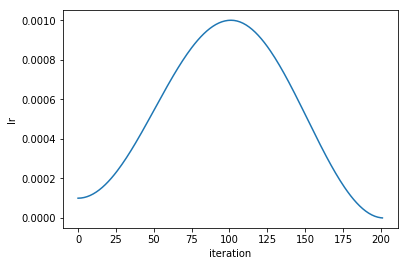

In [ ]:
recorder.plotLRs()

## Export

In [ ]:
notebookToScript(fname: Path.cwd / "09_optimizer.ipynb")